In [238]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, balanced_accuracy_score, f1_score
import numpy as np
from collections import Counter
from scipy.stats import t
from scipy.stats import poisson
from numpy import sum as arraysum
from numpy import sqrt
import matplotlib.pyplot as plt
import geopandas
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Question 1 (Prediction)

In [2]:
qn1_data = pd.read_csv('data/annual-motor-vehicle-inspection-passing-rate-of-motor-vehicles-on-first-inspection/' \
                       'annual-motor-vehicle-inspection-passing-rate-of-motor-vehicles-on-first-inspection.csv')

In [3]:
# Focus on motorcycles
qn1_data = qn1_data[qn1_data['type']=='Motorcycles']

In [4]:
qn1_data.head()

,year,type,age,number_reported,number_passed,passing_rate
11,2006,Motorcycles,1,343,329,95.9
12,2006,Motorcycles,2,577,541,93.8
13,2006,Motorcycles,3,16235,15066,92.8
14,2006,Motorcycles,4,15695,14686,93.6
15,2006,Motorcycles,5,12434,11456,92.1


In [5]:
qn1_data['year'].unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017])

## **Task 1**: What's the average passing rate on first inspection each year, taking into account motorcycles of all age groups?

In [6]:
print('The average passing rate on first inspection of motorcycles each year (averaged across age) is:')
qn1_task1 = qn1_data.groupby('year')['passing_rate'].mean()
qn1_task1

The average passing rate on first inspection of motorcycles each year (averaged across age) is:


year
2006    92.990909
2007    93.686925
2008    93.870527
2009    93.873521
2010    93.981256
2011    94.045351
2012    92.791833
2013    89.050335
2014    83.116493
2015    86.459294
2016    87.506665
2017    87.604945
Name: passing_rate, dtype: float64

## **Task 2**: For motorcycles of each age, estimate their passing rate next year.
*Candidate's Assumption: Since the question says motorcycles of each age, we assume that we are asked to estimate their passing rate on 2018 (unseen data)*

In [7]:
max_year = qn1_data['year'].max()
print('As the final year we have is 2017, our input data will only hold until 2016 data.')

As the final year we have is 2017, our input data will only hold until 2016 data.


In [8]:
qn1_data['age_next_year'] = qn1_data['age'].apply(lambda x: '>10' if (x in ('10', '>10')) else str(int(x)+1))

In [10]:
qn1_data['next_year_key'] = qn1_data.apply(lambda x: str(x['year']+1) + '_' + str(x['age_next_year']), axis=1)
qn1_data['cur_year_key'] = qn1_data.apply(lambda x: str(x['year']) + '_' + str(x['age']), axis=1)

In [11]:
qn1_task2 = qn1_data[['year', 'age', 'next_year_key', 'passing_rate']].merge(qn1_data[['cur_year_key', 'passing_rate']], left_on='next_year_key', right_on='cur_year_key')
qn1_task2 = qn1_task2[['year', 'age', 'passing_rate_x', 'passing_rate_y']]
qn1_task2 = qn1_task2.rename(columns={'passing_rate_x': 'passing_rate', 'passing_rate_y': 'next_year_passing_rate'})

In [12]:
qn1_task2.head()

,year,age,passing_rate,next_year_passing_rate
0,2006,1,95.9,95.081967
1,2006,2,93.8,93.954486
2,2006,3,92.8,94.100719
3,2006,4,93.6,94.135310
4,2006,5,92.1,93.292835


Perform encoding of Age column

In [13]:
qn1_task2['age'] = qn1_task2['age'].astype("category")
qn1_task2_dummy = pd.get_dummies(qn1_task2)

Construct train test split

In [24]:
X, y = qn1_task2_dummy.drop(columns=['year', 'next_year_passing_rate']), qn1_task2_dummy['next_year_passing_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

Scale the input columns and output

In [25]:
feature_scaler = MinMaxScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)
target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test = target_scaler.transform(np.array(y_test).reshape(-1,1))

Initialise model and cross validate on 3 folds

In [53]:
model = LinearRegression()
folds = KFold(n_splits = 3, shuffle = True, random_state = 43)
scores = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], cv=folds)

In [54]:
scores

{'fit_time': array([0.00231814, 0.00106597, 0.00128412]),
 'score_time': array([0.00136495, 0.00079799, 0.00112891]),
 'test_r2': array([-2.83759990e-01,  1.72827291e-02, -3.11506860e+01]),
 'test_neg_mean_squared_error': array([-0.07788434, -0.05544759, -1.78053069])}

In [55]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Model performance on holdout set

In [56]:
print("\nMean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


Mean squared error: 0.07
Coefficient of determination: -0.51


Train the model on the **entire 2006 to 2016 dataset** and format answer to the question.

In [62]:
model = LinearRegression()
feature_scaler = MinMaxScaler()
X_full = feature_scaler.fit_transform(X)
target_scaler = MinMaxScaler()
y_full = target_scaler.fit_transform(np.array(y).reshape(-1,1))
model.fit(X_full, y_full)

LinearRegression()

In [63]:
answer_X = qn1_data[qn1_data['year']==2017][['age', 'passing_rate']]
answer_X['age'] = answer_X['age'].astype('category')
answer_X = pd.get_dummies(answer_X)
answer_X = feature_scaler.transform(answer_X)
estimated_passing = target_scaler.inverse_transform(model.predict(answer_X))

In [64]:
temp_df = pd.DataFrame(answer_X, columns=X.columns)
qn1_task2_answer = pd.DataFrame()
qn1_task2_answer['age'] = temp_df[['age_1', 'age_10', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_7', 'age_8', 'age_9', 'age_>10']].idxmax(axis=1)
qn1_task2_answer['age'] = qn1_task2_answer['age'].apply(lambda x: x.replace('age_',''))
qn1_task2_answer['estimated_passing_rate_2018'] = estimated_passing

In [65]:
print('Estimated passing rate next year - 2018:')
qn1_task2_answer

Estimated passing rate next year - 2018:


,age,estimated_passing_rate_2018
0,1,95.540096
1,2,93.354100
2,3,93.549278
3,4,93.549278
4,5,93.549278
5,6,93.549278
6,7,93.471207
7,8,93.510242
8,9,93.588314
9,10,92.690493


## Task 3: Assuming your estimated rates are true, can you suggest a sensible range of possible passing ranges for motorcycles in the 5-year age group next year, with at least 95% possibility of including the actual passing rate? If you can come up with multiple ranges that meet this criteria, use the one with the narrowest range. You may assume the number of motorcycles is the same as the number in the 4-year age group in the previous year.

In [85]:
# Compute prediction interval
def predict_interval(X_train, y_train, X, model, target_scaler):
    n = X_train.shape[0]
    alpha = 0.05
    t_stat = t.ppf(1-alpha/2, df=n-2)
    
    # Find training error
    y_pred = model.predict(X_train)
    # Calculate interval upper and lower boundaries
    sum_errs = arraysum((y_train - y_pred)**2)
    stdev = sqrt(1/(len(y_train)-2) * sum_errs)
    interval = t_stat * stdev
    
    y_pred = model.predict(X)
    lower = y_pred - interval
    upper = y_pred + interval
    y_pred = target_scaler.inverse_transform(y_pred)[0][0]
    lower = target_scaler.inverse_transform(lower)[0][0]
    upper = target_scaler.inverse_transform(upper)[0][0]
    
    return lower, upper, y_pred

In [78]:
# Retain only 4-year age group in 2017 dataset
qn1_task3_data = qn1_data[qn1_data['year']==2017][['age', 'passing_rate']]
qn1_task3_data['age'] = qn1_task3_data['age'].astype('category')
qn1_task3_data = pd.get_dummies(qn1_task3_data)
qn1_task3_data = qn1_task3_data[qn1_task3_data['age_4']==1]
qn1_task3_data = feature_scaler.transform(qn1_task3_data)

In [86]:
qn1_task_3_answer = predict_interval(X_full, y_full, qn1_task3_data, model, target_scaler)

In [89]:
print('The range of possible passing ranges for motorcycles in the 5-year age group in 2018 (95% sig level) is:\n' \
     f'Lower Boundary: {qn1_task_3_answer[0]}\n' \
     f'Upper Boundary: {qn1_task_3_answer[1]}\n' \
     f'Predicted Value: {qn1_task_3_answer[2]}')

The range of possible passing ranges for motorcycles in the 5-year age group in 2018 (95% sig level) is:
Lower Boundary: 89.1154563917162
Upper Boundary: 97.98309937789318
Predicted Value: 93.54927788480468


---

# Question 2 (Association)

In [2]:
qn2_data = pd.read_csv('data/cea-salesperson-residential-transaction-record/' \
                       'cea-salespersons-property-transaction-records-residential.csv')

/var/folders/wx/6glkypnn5pd_cjs1cdkt0v6m0000gn/T/ipykernel_12066/1604338329.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  qn2_data = pd.read_csv('data/cea-salesperson-residential-transaction-record/' \


In [3]:
print('represented unique values:', qn2_data['represented'].unique())
print('property_type unique values:', qn2_data['property_type'].unique())
print('transaction_type unique values:', qn2_data['transaction_type'].unique())

represented unique values: ['BUYER' 'SELLER' 'LANDLORD' 'TENANT']
property_type unique values: ['HDB' 'CONDOMINIUM_APARTMENTS' 'STRATA_LANDED' 'LANDED'
 'EXECUTIVE_CONDOMINIUM']
transaction_type unique values: ['RESALE' 'WHOLE RENTAL' 'ROOM RENTAL' 'NEW SALE' 'SUB-SALE']


In [4]:
# Focus on HDB resale transaction where agent represented seller
qn2_data = qn2_data[(qn2_data['represented']=='SELLER') & (qn2_data['property_type']=='HDB') & (qn2_data['transaction_type']=='RESALE')]

In [5]:
qn2_data.shape

(140969, 9)

In [6]:
qn2_data.head()

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
1,LIM JOO HENG,AUG-2018,R011043H,HDB,RESALE,SELLER,BUKIT PANJANG,-,-
2,WONG TSU HAW,MAY-2017,R045055G,HDB,RESALE,SELLER,BUKIT PANJANG,-,-
3,TAY BEE KIAT,JUL-2018,R056733J,HDB,RESALE,SELLER,BUKIT PANJANG,-,-
5,BAI YIXIANG KEVIN,JAN-2017,R041704E,HDB,RESALE,SELLER,SENGKANG,-,-
7,CHEONG POH YENG,MAY-2017,R052220E,HDB,RESALE,SELLER,SENGKANG,-,-


## **Task 1:** Based on the dataset, how many sales would you expect an agent to close each year? How much variation is there among agents? 
*Candidate's note: There are 3 ways in which we can compute the average sales. After aggregating number of sales closed by agent and year, we can:* \
*1. Treat each row as individual agents and simply average across all rows for the `sales` column* \
*2. Find the average `sales` by year, then average the averages of each year* \
*3. Find the average `sales` by agent registration number across their years of sales, then average the averages of each agent* \
*Candidate's assumption: For simplicity sake, we choose method 1 so that in Task 2 each observation is discrete.*

In [7]:
qn2_task1 = qn2_data[['salesperson_reg_num', 'transaction_date']]
qn2_task1['year'] = qn2_task1['transaction_date'].apply(lambda x: x.split('-')[-1])

/var/folders/wx/6glkypnn5pd_cjs1cdkt0v6m0000gn/T/ipykernel_12066/1253372095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qn2_task1['year'] = qn2_task1['transaction_date'].apply(lambda x: x.split('-')[-1])


In [8]:
qn2_task1['year'].unique()

array(['2018', '2017', '2019', '2020', '2021', '2022', '2023'],
      dtype=object)

In [9]:
qn2_task1_agg_by_agent_and_year = pd.DataFrame(qn2_task1.groupby(['salesperson_reg_num', 'year'])['year'].count())
qn2_task1_agg_by_agent_and_year.columns=['sales']
qn2_task1_agg_by_agent_and_year

sales
salesperson_reg_num year       
P000001B            2018      1
                    2019      1
                    2021      1
P000003I            2017      2
                    2018      3
...                         ...
R067053H            2023      1
R067134H            2023      1
R067188I            2023      1
R067232I            2023      1
R067264B            2023      1

[48912 rows x 1 columns]

In [10]:
# Method 1 computation
expected_sales = round(qn2_task1_agg_by_agent_and_year['sales'].mean(),2)
print(f'An agent is expected to close {expected_sales} sales each year.')

An agent is expected to close 2.88 sales each year.


In [11]:
def calc_sd_var(data, mean):
    # Alternatively use .std() and .var() methods
    var = sum([(x-mean)**2 for x in data]) / len(data)
    sd = var**(0.5)
    
    return round(var,2), round(sd,2)

In [12]:
data_var, data_std = calc_sd_var(qn2_task1_agg_by_agent_and_year['sales'], expected_sales)
print(f'The variance is {data_var} and standard deviation is {data_std} among the agents.')

The variance is 25.08 and standard deviation is 5.01 among the agents.


## **Task 2:** Examine the distribution for number of sales closed by an agent in a year & suggest a probability distribution that may be suitable for modelling this set of values. What are some ways in which your suggested distribution is appropriate? What are some of its limitations?

In [13]:
sales_distribution = qn2_task1_agg_by_agent_and_year['sales'].values

(array([4.783e+04, 7.810e+02, 1.930e+02, 5.200e+01, 2.100e+01, 1.300e+01,
        5.000e+00, 6.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  1.        ,  13.77777778,  26.55555556,  39.33333333,
         52.11111111,  64.88888889,  77.66666667,  90.44444444,
        103.22222222, 116.        , 128.77777778, 141.55555556,
        154.33333333, 167.11111111, 179.88888889, 192.66666667,
        205.44444444, 218.22222222, 231.        ]),
 <BarContainer object of 18 artists>)

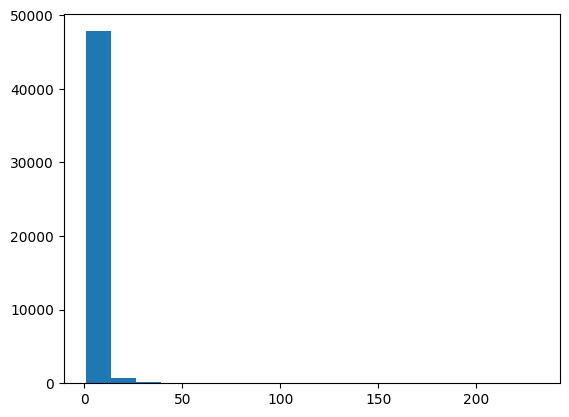

In [16]:
plt.hist(sales_distribution, bins = int(180/10))

(array([2.3742e+04, 0.0000e+00, 9.8740e+03, 5.2700e+03, 3.0260e+03,
        3.0810e+03, 1.4440e+03, 1.0760e+03, 5.7100e+02, 3.4700e+02,
        1.9700e+02, 1.5000e+02, 7.3000e+01, 3.0000e+01, 1.6000e+01,
        5.0000e+00, 4.0000e+00, 6.0000e+00]),
 array([0.        , 0.30235654, 0.60471308, 0.90706962, 1.20942616,
        1.5117827 , 1.81413924, 2.11649578, 2.41885232, 2.72120886,
        3.02356539, 3.32592193, 3.62827847, 3.93063501, 4.23299155,
        4.53534809, 4.83770463, 5.14006117, 5.44241771]),
 <BarContainer object of 18 artists>)

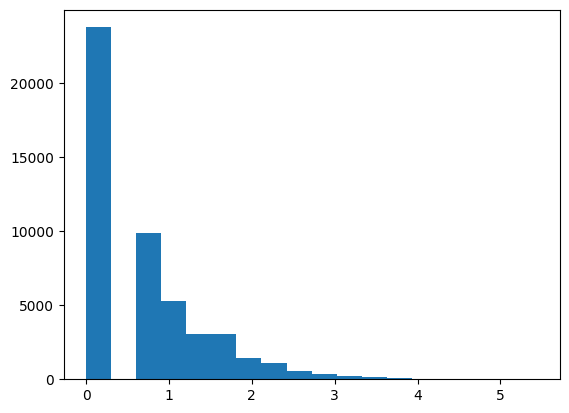

In [17]:
# Since it is a skewed dataset, we do a plot of the log values
plt.hist(np.log(sales_distribution), bins = int(180/10))

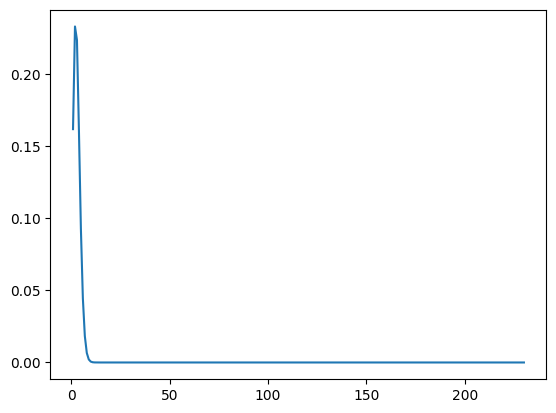

In [18]:
# Plot PMF of Poisson (Mu = Expected Sales)
sales_ranges = np.arange(sales_distribution.min(), sales_distribution.max(), 1)
prob_val = poisson.pmf(k=sales_ranges, mu=expected_sales)
plt.plot(sales_ranges, prob_val)
plt.show()

We notice that the Poisson distribution plotted above looks similar to that of our HDB Resale sales distribution plot.

I would go with Poisson distribution to model this set of values for a start. The reasons are as follow:
- Number of sales closures each year is discrete.
- Poisson distribution estimation is done within a given interval of time or space, in our case will be within a year.
- Poisson distribution only requires 1 parameter, lambda, which is the mean of sales.

Some limitations are as follow:
- Given the condition of poisson distribution is that all events are independent, it might difficult to ensure so (i.e. agent referral). However, given HDB restrictions such as every customer can only own 1 HDB and there are no showroom events like Condominium does, it greatly reduces the likelihood of sales being dependent. Similarly, some agent might be more skilled than the other, which result in higher probability of HDB resales closed.
- Assumption that the average rate of sales does not change during the period of interest -> This might not hold across the years due to events and change in seasonalities (e.g. a change in goverment housing policies which might affect home purchasing decisions or economic downturn). On top of that, the rate differs among agents as well.

Furthermore, since the variance is larger than the mean (25.08 > 2.88), there is over-dispersion which violates the assumption of Poisson distribution (variance = mean). There are other issues such as omission of zero values (i.e. agents who did not close any sales) and attributes/features of individual agents which might lead to a higher probability of closing a sale. Hence, depending on the end use case and availability of supplementary data, we can adopt more suitable models such as mixed Poisson (negative binomial) and zero-inflated models.

## Task 3: Property agents tend to specialise in one or more specific geographical areas, rather than ply their trade equally island-wide. Given a property agent who has closed sales in Sembawang and Yishun during a given year, which other town is he/she most likely to be active in that year? (Note: you may wish to use association rules for this task.)

In [33]:
# Create geographical area dataset as records
qn2_task3 = qn2_data.copy()
qn2_task3['year'] = qn2_task3['transaction_date'].apply(lambda x: x.split('-')[-1])
qn2_task3 = qn2_task3[['salesperson_reg_num', 'year', 'town']].drop_duplicates()
qn2_task3 = qn2_task3.groupby(['salesperson_reg_num', 'year'])['town'].apply(list).reset_index()

In [35]:
qn2_task3.head()

,salesperson_reg_num,year,town
0,P000001B,2018,[BEDOK]
1,P000001B,2019,[QUEENSTOWN]
2,P000001B,2021,[BEDOK]
3,P000003I,2017,"[YISHUN, CHOA CHU KANG]"
4,P000003I,2018,"[CHOA CHU KANG, SEMBAWANG, JURONG WEST]"


In [37]:
# Filter for agents who work in towns inclusive of sembawang and yishun -> Store the other towns they work in
other_towns = []
for idx, row in qn2_task3.iterrows():
    if (('SEMBAWANG' in row['town']) & ('YISHUN' in row['town'])):
        other_towns += [town for town in row['town'] if town not in ['SEMBAWANG', 'YISHUN']]

In [38]:
other_towns_freq = Counter(other_towns)
other_towns_freq_df = pd.DataFrame({'Town': other_towns_freq.keys(), 'Freq': other_towns_freq.values()})
other_towns_freq_df = other_towns_freq_df.sort_values(by='Freq', ascending=False)

In [39]:
other_towns_freq_df.head()

,Town,Freq
13,WOODLANDS,416
8,SENGKANG,331
10,PUNGGOL,283
3,JURONG WEST,261
9,CHOA CHU KANG,257


This is akin to calculating confidence where confidence = `Support(Sembawang & Yishun & [Town])` / `Support(Sembawang & Yishun)`. \
 \
Since `Support(Sembawang & Yishun)` is a constant, we only need to focus on `Support(Sembawang & Yishun & [Town])`. As `Support(Sembawang & Yishun & [Town])` is reliant on frequency, we can infer that `Support(Sembawang & Yishun & Woodlands)` will have the highest support => highest confidence. \
 \
Therefore, given a property agent who has closed sales in Sembawang and Yishun during a given year, the other town he/she is most likely to be active in that year is **Woodlands**.

---

# Question 3 (Classification)

In [142]:
qn3_data = geopandas.read_file('data/wireless-hotspots/' \
                       'wireless-hotspots-geojson.geojson')

In [143]:
def parse_html(content):
    df = pd.read_html(content)[0]
    df = df.set_index('Attributes')
    df = df.T.reset_index(drop=True)
    df = df.rename_axis(None, axis=1)
    return df


In [144]:
qn3_temp_df = pd.DataFrame()
for idx, row in qn3_data.iterrows():
    content = row['Description']
    temp_table = parse_html(content)
    qn3_temp_df = pd.concat([qn3_temp_df, temp_table])

In [145]:
qn3_data = pd.concat([qn3_data.reset_index(drop=True), qn3_temp_df.reset_index(drop=True)], axis=1)

In [146]:
qn3_data.head()

,Name,Description,geometry,Y,X,LOCATION_NAME,LOCATION_TYPE,POSTAL_CODE,STREET_ADDRESS,OPERATOR_NAME,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.74751 1.35019 0.00000),36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83609 1.42804 0.00000),45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85298 1.30020 0.00000),31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84648 1.28633 0.00000),29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.88965 1.39923 0.00000),42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531


## Task 1: From the table, what are some of the information you can deduce for each hotspot?

We are able to deduce the location name, location type, postal code, street address and operator name for each hotspot from the initial description column.

## Task 2: Due to a system error, the location type column for the last 200 rows of the dataset has become garbled. Using all earlier rows as well as all other columns in the dataset, build a classification model to predict the location type for these hotspots. You may treat the three rarest location types as one category. (Note: you may wish to create some additional features based on available ones.)

In [147]:
location_type_freq = Counter(qn3_data['LOCATION_TYPE'])
location_type_freq_df = pd.DataFrame({'Location_Type': location_type_freq.keys(), 'Freq': location_type_freq.values()})
location_type_freq_df = location_type_freq_df.sort_values(by=['Freq'], ascending=[False])

In [148]:
location_type_freq_df.tail()

,Location_Type,Freq
11,Retail Shop,23
9,Shopping Mall,16
6,Tourist Attraction,12
10,Dormitory / Care Centre,4
8,Public Worship,2


In [149]:
# Group the three rarest location types as one category
qn3_task2 = qn3_data.copy()
qn3_task2['LOCATION_TYPE'] = qn3_task2['LOCATION_TYPE'].apply(lambda x: 'TA / D / CC / PW' 
                                                              if x in ('Tourist Attraction', 'Dormitory / Care Centre', 'Public Worship') 
                                                              else x)

### Feature Engineering

In [150]:
# To utilise postal code without having too high cardinality, we can reduce to sector code (i.e. first two digits)
qn3_task2['SECTOR_CODE'] = qn3_task2['POSTAL_CODE'].apply(lambda x: x[:2])
unique_sec_code = qn3_task2['SECTOR_CODE'].unique()
print(f'SECTOR_CODE has {len(unique_sec_code)} unique values')

SECTOR_CODE has 76 unique values


76 unique values is still too high, we can further group it into Postal Districts to reduce to 28 (29 to include potential unknown cases)

In [151]:
# Source: https://www.mingproperty.sg/singapore-district-code/
# Note: I would prefer an official site like 
#       https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm
#       but the specific page is down
def postal_district_mapper(sector_code):
    code = int(sector_code)
    if code in (1,2,3,4,5,6):
        return '01'
    elif code in (7,8):
        return '02'
    elif code in (14,15,16):
        return '03'
    elif code in (9,10):
        return '04'
    elif code in (11,12,13):
        return '05'
    elif code == 17:
        return '06'
    elif code in (18,19):
        return '07'
    elif code in (20,21):
        return '08'
    elif code in (22,23):
        return '09'
    elif code in (24,25,26,27):
        return '10'
    elif code in (28,29,30):
        return '11'
    elif code in (31,32,33):
        return '12'
    elif code in (34,35,36,37):
        return '13'
    elif code in (38,39,40,41):
        return '14'
    elif code in (42,43,44,45):
        return '15'
    elif code in (46,47,48):
        return '16'
    elif code in (49,50,81):
        return '17'
    elif code in (51,52):
        return '18'
    elif code in (53,54,55,82):
        return '19'
    elif code in (56,57):
        return '20'
    elif code in (58,59):
        return '21'
    elif code in (60,61,62,63,64):
        return '22'
    elif code in (65,66,67,68):
        return '23'
    elif code in (69,70,71):
        return '24'
    elif code in (72,73):
        return '25'
    elif code in (77,78):
        return '26'
    elif code in (75,76):
        return '27'
    elif code in (79,80):
        return '28'
    else:
        return 'UNK'

In [152]:
qn3_task2['POSTAL_DISTRICT'] = qn3_task2['SECTOR_CODE'].apply(lambda x: postal_district_mapper(x))

`LOCATION_NAME` field is definitely very informative as it often contains words related to the Location Type. We will convert the field into word embedding / TF-IDF to be used as features

In [218]:
qn3_task2['PP_LOC_NAME'] = qn3_task2['LOCATION_NAME'].apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())

In [259]:
vect = TfidfVectorizer(
    stop_words='english',
    max_features = 500,
    ngram_range=(1,2))
words_vector = vect.fit_transform(qn3_task2['PP_LOC_NAME'])

### Split Dataset

In [260]:
qn3_task2.head()

,Name,Description,geometry,Y,X,LOCATION_NAME,LOCATION_TYPE,POSTAL_CODE,STREET_ADDRESS,OPERATOR_NAME,INC_CRC,FMEL_UPD_D,SECTOR_CODE,POSTAL_DISTRICT,PP_LOC_NAME
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.74751 1.35019 0.00000),36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531,65,23,bukit batok cc
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.83609 1.42804 0.00000),45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531,76,27,1 northpoint drive
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.85298 1.30020 0.00000),31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531,18,07,155 waterloo st
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84648 1.28633 0.00000),29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531,05,01,20 upper pickering st
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.88965 1.39923 0.00000),42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531,54,19,7 star canteen


In [261]:
# Dummy encoding for categorical variables
qn3_task2_data_X = qn3_task2[['OPERATOR_NAME', 'POSTAL_DISTRICT']]
qn3_task2_data_y = qn3_task2[['LOCATION_TYPE']]
for col in qn3_task2_data_X.columns:
    qn3_task2_data_X[col] = qn3_task2_data_X[col].astype('category')
qn3_task2_data_X = pd.get_dummies(qn3_task2_data_X)

/var/folders/wx/6glkypnn5pd_cjs1cdkt0v6m0000gn/T/ipykernel_12625/1947261485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qn3_task2_data_X[col] = qn3_task2_data_X[col].astype('category')
/var/folders/wx/6glkypnn5pd_cjs1cdkt0v6m0000gn/T/ipykernel_12625/1947261485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qn3_task2_data_X[col] = qn3_task2_data_X[col].astype('category')


In [262]:
# Combine word vector with our categorical variables
sdf = pd.DataFrame.sparse.from_spmatrix(words_vector, columns=vect.get_feature_names_out())
qn3_task2_data_X = pd.concat([qn3_task2_data_X, sdf], axis=1)

In [308]:
X_train = qn3_task2_data_X.iloc[:-200,]
y_train = qn3_task2_data_y[:-200]
X_test = qn3_task2_data_X.iloc[-200:,]
y_test = qn3_task2_data_y[-200:]

In [309]:
# Upsample to handle class imbalance
print(Counter(y_train['LOCATION_TYPE']))
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Counter({'Community': 555, 'Healthcare': 363, 'F&B': 323, 'Welfare Organisation': 122, 'Commercial': 117, 'Public Transport': 30, 'Government': 24, 'Retail Shop': 20, 'TA / D / CC / PW': 18, 'School': 16, 'Shopping Mall': 12})


/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [310]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)

/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For the start, our baseline model will be randomly guessing one of the 11 Location Types. This gives us 9% accuracy. This allow us to compare our machine learning models to see if it is performing better than random guessing.

In [311]:
baseline_score = round(1/len(qn3_task2['LOCATION_TYPE'].unique()),2)

In [312]:
baseline_score

0.09

Experiment with RandomForestClassifier

In [313]:
model = RandomForestClassifier()

In [314]:
folds = StratifiedKFold(n_splits = 3)
scores = cross_validate(model, X_train, y_train, scoring=['accuracy', 'f1_weighted', 'balanced_accuracy'], cv=folds)

/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with spa

In [316]:
scores

{'fit_time': array([0.55131698, 0.55005598, 0.56949902]),
 'score_time': array([0.03973699, 0.04187894, 0.039711  ]),
 'test_accuracy': array([0.96658477, 0.95380835, 0.98230958]),
 'test_f1_weighted': array([0.9666995 , 0.95314967, 0.98230708]),
 'test_balanced_accuracy': array([0.96658477, 0.95380835, 0.98230958])}

From the metrics within cross validation of 3 folds, we observe high performance of our Random Forest model (>0.96).

## Task 3: The information has now been recovered from a backup copy of the file. Compared to the true location types, how good was your model? Be prepared to explain the metrics you use to evaluate your model.

In [317]:
def evaluate_test(model, X_train, y_train, X_test, y_test, le):
    model.fit(X_train, y_train)
    y = le.transform(y_test)
    y_pred = model.predict(X_test)
    print(Counter(y_pred))
    print('Acc:', accuracy_score(y, y_pred))
    print('Balanced Acc:', balanced_accuracy_score(y, y_pred))
    print('F1 (Weighted):', f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    return y_pred

In [318]:
y_pred = evaluate_test(model, X_train, y_train, X_test, y_test, le)

/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Counter({2: 101, 3: 60, 5: 15, 7: 9, 0: 8, 8: 6, 4: 1})
Acc: 0.66
Balanced Acc: 0.4293635531135531
F1 (Weighted): 0.6706835596596744
              precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.00      0.00      0.00         2
           2       1.00      0.96      0.98       105
           3       0.00      0.00      0.00         1
           4       1.00      0.02      0.04        52
           5       1.00      0.94      0.97        16
           6       0.00      0.00      0.00         3
           7       0.89      1.00      0.94         8
           8       0.67      1.00      0.80         4
          10       0.00      0.00      0.00         1

    accuracy                           0.66       200
   macro avg       0.49      0.43      0.41       200
weighted avg       0.93      0.66      0.67       200



/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhunhung/Desktop/GovTech/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Overall, our model performs decently well on our holdout dataset (unseen) with 0.67 F1-weighted score. This is much better than our baseline random model. As there is severe class imbalance among the holdout dataset, I chose metrics such as `balanced_accuracy` and `f1_score_weighted` to account for the imbalance when comparing metrics. `balanced_accuracy` is defined the same way as `macro avg recall` (i.e. sum of recall of all classes divided by number of classes) and `f1_score_weighted` does a weighted average of F1-Score by the class count. \
 \
We can attempt to further improve the model by looking at the mistakes it made. For example, looking at Class 4 where it has a recall of 0.02 and precision of 1.00. This class represents `Healthcare`, which makes up ~25% of the holdout set.

In [319]:
eval_df = y_test.copy()
eval_df['PRED_LOCATION_TYPE'] = le.inverse_transform(y_pred)
eval_df = pd.concat([qn3_task2[['LOCATION_NAME', 'OPERATOR_NAME','POSTAL_DISTRICT']].iloc[-200:,], eval_df], axis=1)
eval_df_health = eval_df[eval_df['LOCATION_TYPE']=='Healthcare']

In [320]:
eval_df_health.head()

,LOCATION_NAME,OPERATOR_NAME,POSTAL_DISTRICT,LOCATION_TYPE,PRED_LOCATION_TYPE
1600,National University Hospital,Singtel,05,Healthcare,Commercial
1606,Ng Teng Fong Hospital - Annex_Building,Singtel,22,Healthcare,Government
1607,Ng Teng Fong Hospital - Clinic_Tower(SOC)_B1,Singtel,22,Healthcare,Government
1608,Ng Teng Fong Hospital - Clinic_Tower(SOC)_B2,Singtel,22,Healthcare,Government
1609,Ng Teng Fong Hospital - Clinic_Tower(SOC)_L1,Singtel,22,Healthcare,Government


In [321]:
Counter(eval_df_health['PRED_LOCATION_TYPE'])

Counter({'Commercial': 1, 'Government': 50, 'Healthcare': 1})

Given more time, we could utilise the following approach to improve the model further:
1. Utilise SHAP values to understand **local importance** of features contributing most to each of these misclassified observation.
2. Words like 'hospital', 'clinic' exist in our word vectors. However, it is possible that other features (words) might have had a stronger influence. From the observations, `Government` location type is most commonly predicted instead of `Healthcare`. Thus, there might be overlap of location name words.
3. Having this understanding, we can then introduce further preprocessing to make the distinction clearer for the model and hopefully improve the recall of `Healthcare` and the overall performance of the model

Lastly, hyperparameter tuning for our RandomForestClassifier can be the followup approach to further improve our model after finetuning the feature engineering methodology as mentioned above.

# Question 4 (Visualization)

## Task: Help your colleague present the insight in an intuitive manner that is easily understood by a non-technical audience, and that reflects as many characteristics in the list as possible. Be prepared to justify any and every aspect of your visualisation (e.g. chart choice, colour palette, labels, orientation, etc.).

Visualization can be found here: \
https://lookerstudio.google.com/reporting/56e36a69-5b96-4752-b8ee-c63bbc83562d \
 \
It is also attached as a PDF file for offline viewing, `GovTech_Interview_Question_4_(Visualisation)_-_YongZhunHung.pdf`

*Candidate Note: I used placeholders for the name of the specific course and year so that the colleague can easily substitute in.*